<a href="https://colab.research.google.com/github/SeounghwanPark/nesaram/blob/main/MainQuest05_r2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. 라이브러리 및 데이터 불러오기**

In [2]:
# 기본 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Google Drive 마운트 (Colab 사용)
from google.colab import drive
drive.mount('/content/drive/')

# Pandas 옵션 설정 (모든 컬럼 출력)
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


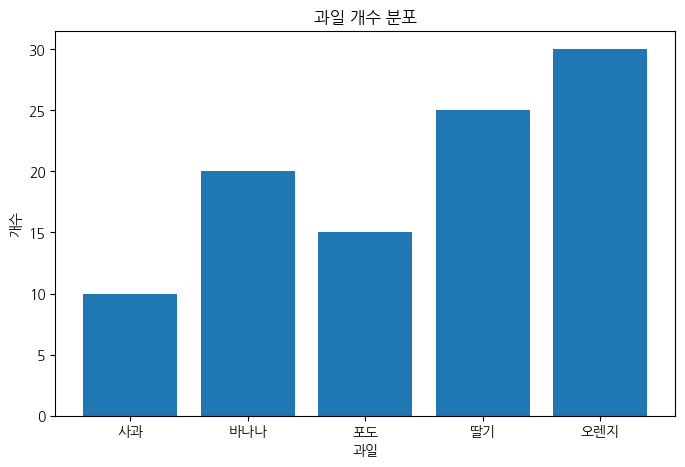

In [3]:
# 1. 한글 폰트 설치 (Google Colab 전용)
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 2. matplotlib에서 한글 폰트 설정
def set_korean_font():
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 폰트 경로 설정
    if os.path.exists(font_path):
        fm.fontManager.addfont(font_path)  # 폰트 매니저에 추가
        plt.rc('font', family='NanumGothic')  # 기본 폰트 설정
    else:
        print("한글 폰트 경로를 찾을 수 없습니다.")

# 3. 폰트 적용 및 캐시 리셋 (중요)
set_korean_font()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
fm._load_fontmanager(try_read_cache=False)  # 폰트 매니저 캐시 리셋

# 4. 한글 폰트 적용 확인을 위한 테스트 그래프
labels = ['사과', '바나나', '포도', '딸기', '오렌지']
values = [10, 20, 15, 25, 30]

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.xlabel("과일")
plt.ylabel("개수")
plt.title("과일 개수 분포")
plt.show()

**데이터 로딩**

In [4]:
# 데이터 로드 (파일 경로)
aisles_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/aisles.csv')
departments_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/departments.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/orders.csv')
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__prior.csv')
order_products_train_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__train.csv')
products_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/products.csv')


# 모든 컬럼이 출력
pd.set_option('display.max_columns', None)

dataframes = {
    "aisles_df": aisles_df,
    "departments_df": departments_df,
    "orders_df": orders_df,
    "order_products_prior_df": order_products_prior_df,
    "order_products_train_df": order_products_train_df,
    "products_df": products_df
}

for name, df in dataframes.items():
    print("=" * 50)
    print(f"{name}")  # 데이터프레임 이름 출력
    print("=" * 50)

    # 데이터프레임 정보 출력
    info_df = pd.DataFrame({
        "Columns": df.columns,
        "Non-Null Count": [df[col].count() for col in df.columns],
        "Dtype": [df[col].dtype for col in df.columns]
    })
    print("\n데이터셋 정보")
    display(info_df)  # 테이블 형태로 출력

    # 데이터프레임 전체 출력
    print(f"\n{name} 데이터셋 (총 {df.shape[0]} 행 × {df.shape[1]} 열)")
    display(df)  # 테이블 형태로 출력


aisles_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,aisle_id,134,int64
1,aisle,134,object



aisles_df 데이터셋 (총 134 행 × 2 열)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


departments_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,department_id,21,int64
1,department,21,object



departments_df 데이터셋 (총 21 행 × 2 열)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


orders_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,order_id,3421083,int64
1,user_id,3421083,int64
2,eval_set,3421083,object
3,order_number,3421083,int64
4,order_dow,3421083,int64
5,order_hour_of_day,3421083,int64
6,days_since_prior_order,3214874,float64



orders_df 데이터셋 (총 3421083 행 × 7 열)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


order_products_prior_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,order_id,32434489,int64
1,product_id,32434489,int64
2,add_to_cart_order,32434489,int64
3,reordered,32434489,int64



order_products_prior_df 데이터셋 (총 32434489 행 × 4 열)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


order_products_train_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,order_id,1384617,int64
1,product_id,1384617,int64
2,add_to_cart_order,1384617,int64
3,reordered,1384617,int64



order_products_train_df 데이터셋 (총 1384617 행 × 4 열)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


products_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,product_id,49688,int64
1,product_name,49688,object
2,aisle_id,49688,int64
3,department_id,49688,int64



products_df 데이터셋 (총 49688 행 × 4 열)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


**2. 데이터셋별 기초 EDA**

In [17]:
import pandas as pd

# 1. prior 주문 데이터만 사용 (주문 내역)
prior_orders = orders_df[orders_df['eval_set'] == 'prior'].copy()

# 2. orders와 order_products_prior를 결합하여 각 주문의 상품 정보를 추가
prior_orders_products = pd.merge(prior_orders, order_products_prior_df, on='order_id', how='inner')

# 3. 고객별 주요 지표 집계
# - total_orders: 고객의 최대 order_number (고객의 주문 횟수)
# - total_items: 고객이 주문한 전체 상품 수 (행 개수)
# - total_reorders: 고객이 재구매한 상품의 총 개수
# - avg_days_between: 고객별 평균 주문 간격 (NaN은 자동 제외)
customer_segmentation = prior_orders_products.groupby('user_id').agg(
    total_orders = ('order_number', 'max'),
    total_items = ('product_id', 'count'),
    total_reorders = ('reordered', 'sum'),
    avg_days_between = ('days_since_prior_order', 'mean')
).reset_index()

# 4. 추가 지표 생성
# - avg_items_per_order: 주문당 평균 구매 상품 수
# - reorder_rate: 전체 구매 상품 중 재구매 상품의 비율
customer_segmentation['avg_items_per_order'] = customer_segmentation['total_items'] / customer_segmentation['total_orders']
customer_segmentation['reorder_rate'] = customer_segmentation['total_reorders'] / customer_segmentation['total_items']

# 결과 확인
print("고객 세그먼트 데이터셋 미리보기")
display(customer_segmentation.head())

고객 세그먼트 데이터셋 미리보기


,user_id,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate
0,1,10,59,41,20.259259,5.900000,0.694915
1,2,14,195,93,15.967033,13.928571,0.476923
2,3,12,88,55,11.487179,7.333333,0.625000
3,4,5,18,1,15.357143,3.600000,0.055556
4,5,4,37,14,14.500000,9.250000,0.378378


In [5]:
import pandas as pd

# 0. orders_df 수정: 결측치 -1로 대체 및 first_order 컬럼 추가
orders_df["days_since_prior_order"] = orders_df["days_since_prior_order"].fillna(-1)
orders_df["first_order"] = (orders_df["days_since_prior_order"] == -1).astype(int)

# 1. prior 주문 데이터만 사용 (주문 내역)
prior_orders = orders_df[orders_df['eval_set'] == 'prior'].copy()

# 2. orders와 order_products_prior를 결합하여 각 주문의 상품 정보를 추가
prior_orders_products = pd.merge(prior_orders, order_products_prior_df, on='order_id', how='inner')

# 3. 고객별 주요 지표 집계
# - total_orders: 고객의 최대 order_number (고객의 주문 횟수)
# - total_items: 고객이 주문한 전체 상품 수 (행 개수)
# - total_reorders: 고객이 재구매한 상품의 총 개수
# - avg_days_between: 고객별 평균 주문 간격 (NaN은 자동 제외)
customer_segmentation = prior_orders_products.groupby('user_id').agg(
    total_orders=('order_number', 'max'),
    total_items=('product_id', 'count'),
    total_reorders=('reordered', 'sum'),
    avg_days_between=('days_since_prior_order', 'mean')
).reset_index()

# 4. 추가 지표 생성
# - avg_items_per_order: 주문당 평균 구매 상품 수
# - reorder_rate: 전체 구매 상품 중 재구매 상품의 비율
customer_segmentation['avg_items_per_order'] = customer_segmentation['total_items'] / customer_segmentation['total_orders']
customer_segmentation['reorder_rate'] = customer_segmentation['total_reorders'] / customer_segmentation['total_items']

# 5. 고객별 집계 지표를 prior_orders_products 데이터에 매핑 방식으로 추가
#    (pd.merge 대신 각 행의 user_id로 매핑하여 메모리 사용량을 줄임)
agg_columns = ['total_orders', 'total_items', 'total_reorders',
               'avg_days_between', 'avg_items_per_order', 'reorder_rate']

# customer_segmentation을 user_id를 인덱스로 설정한 딕셔너리 형태로 생성
agg_dict = customer_segmentation.set_index('user_id')

# 각 agg_columns에 대해 prior_orders_products의 user_id로 매핑하여 컬럼 추가
for col in agg_columns:
    prior_orders_products[col] = prior_orders_products['user_id'].map(agg_dict[col])

# 최종 결과를 customer_segmentation_total에 저장
customer_segmentation_total = prior_orders_products

# 결과 확인
print("customer_segmentation_total 데이터셋 미리보기")
display(customer_segmentation_total.head())

customer_segmentation_total 데이터셋 미리보기


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,first_order,product_id,add_to_cart_order,reordered,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate
0,2539329,1,prior,1,2,8,-1.0,1,196,1,0,10,59,41,18.457627,5.9,0.694915
1,2539329,1,prior,1,2,8,-1.0,1,14084,2,0,10,59,41,18.457627,5.9,0.694915
2,2539329,1,prior,1,2,8,-1.0,1,12427,3,0,10,59,41,18.457627,5.9,0.694915
3,2539329,1,prior,1,2,8,-1.0,1,26088,4,0,10,59,41,18.457627,5.9,0.694915
4,2539329,1,prior,1,2,8,-1.0,1,26405,5,0,10,59,41,18.457627,5.9,0.694915


In [18]:
#CSV파일 저장 분석 데이터셋 만들기
# customer_segmentation.csv로 저장
customer_segmentation.to_csv("/content/drive/MyDrive/data/MQ05/customer_segmentation.csv", index=False)

print("CSV 파일 저장이 완료되었습니다.")


CSV 파일 저장이 완료되었습니다.


In [19]:
import pandas as pd

# 모든 컬럼을 출력하도록 설정 (필요 시)
pd.set_option('display.max_columns', None)

# 1. CSV 파일 로드
cs_df = pd.read_csv("/content/drive/MyDrive/data/MQ05/customer_segmentation.csv")

# 2. 기본 정보 출력
print("DataFrame Info:")
cs_df.info()

print("\nDataFrame Shape (행, 열):", cs_df.shape)

print("\nColumn Names:")
print(cs_df.columns.tolist())

# 3. 데이터 미리보기
print("\nPreview (head):")
display(cs_df.head())

# 4. 기초 통계량
print("\nBasic Statistics:")
display(cs_df.describe())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              206209 non-null  int64  
 1   total_orders         206209 non-null  int64  
 2   total_items          206209 non-null  int64  
 3   total_reorders       206209 non-null  int64  
 4   avg_days_between     206209 non-null  float64
 5   avg_items_per_order  206209 non-null  float64
 6   reorder_rate         206209 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 11.0 MB

DataFrame Shape (행, 열): (206209, 7)

Column Names:
['user_id', 'total_orders', 'total_items', 'total_reorders', 'avg_days_between', 'avg_items_per_order', 'reorder_rate']

Preview (head):


,user_id,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate
0,1,10,59,41,20.259259,5.900000,0.694915
1,2,14,195,93,15.967033,13.928571,0.476923
2,3,12,88,55,11.487179,7.333333,0.625000
3,4,5,18,1,15.357143,3.600000,0.055556
4,5,4,37,14,14.500000,9.250000,0.378378



Basic Statistics:


,user_id,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,103105.000000,15.590367,157.289396,92.753158,15.469670,9.951586,0.432249
std,59527.555167,16.654774,204.208233,158.400413,7.207436,5.863570,0.212144
min,1.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000
25%,51553.000000,5.000000,39.000000,10.000000,9.553797,5.740741,0.267857
50%,103105.000000,9.000000,83.000000,33.000000,14.692308,8.933333,0.428571
75%,154657.000000,19.000000,188.000000,101.000000,20.724409,13.000000,0.595745
max,206209.000000,99.000000,3725.000000,3275.000000,30.000000,70.250000,0.989529


# 진행 내용 (고객 집단 분류)
orders와 order_products_prior를 결합하여 각 주문의 상품 정보를 추가

고객별 주요 지표 집계

total_orders: 고객의 최대 order_number (고객의 주문 횟수)

total_items: 고객이 주문한 전체 상품 수 (행 개수)

total_reorders: 고객이 재구매한 상품의 총 개수

avg_days_between: 고객별 평균 주문 간격 (NaN은 자동 제외)

# 추가 지표 생성

avg_items_per_order: 주문당 평균 구매 상품 수

reorder_rate: 전체 구매 상품 중 재구매 상품의 비율

Summary Statistics (Max, Mean, Std):


,max,mean,std
user_id,206209.000000,103105.000000,59527.555167
total_orders,99.000000,15.590367,16.654774
total_items,3725.000000,157.289396,204.208233
total_reorders,3275.000000,92.753158,158.400413
avg_days_between,30.000000,15.469670,7.207436
avg_items_per_order,70.250000,9.951586,5.863570
reorder_rate,0.989529,0.432249,0.212144


Missing Values per column:
user_id                0
total_orders           0
total_items            0
total_reorders         0
avg_days_between       0
avg_items_per_order    0
reorder_rate           0
dtype: int64


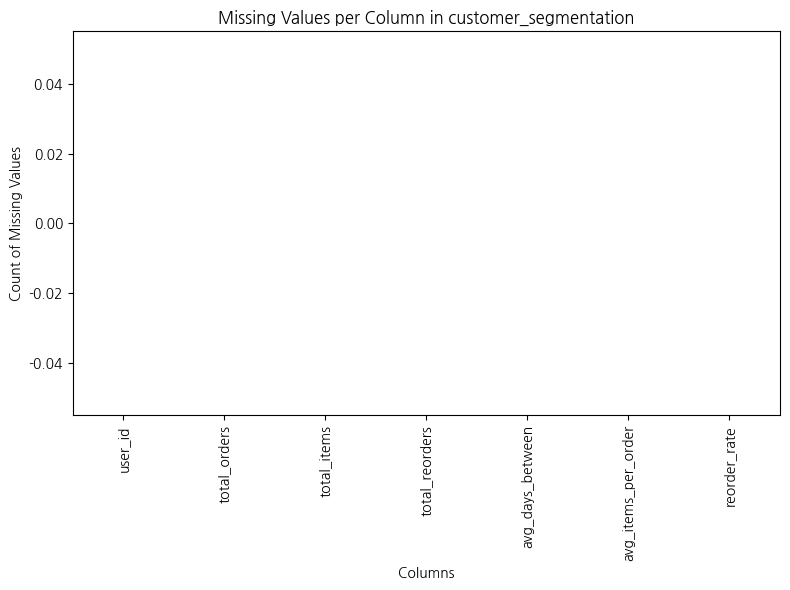

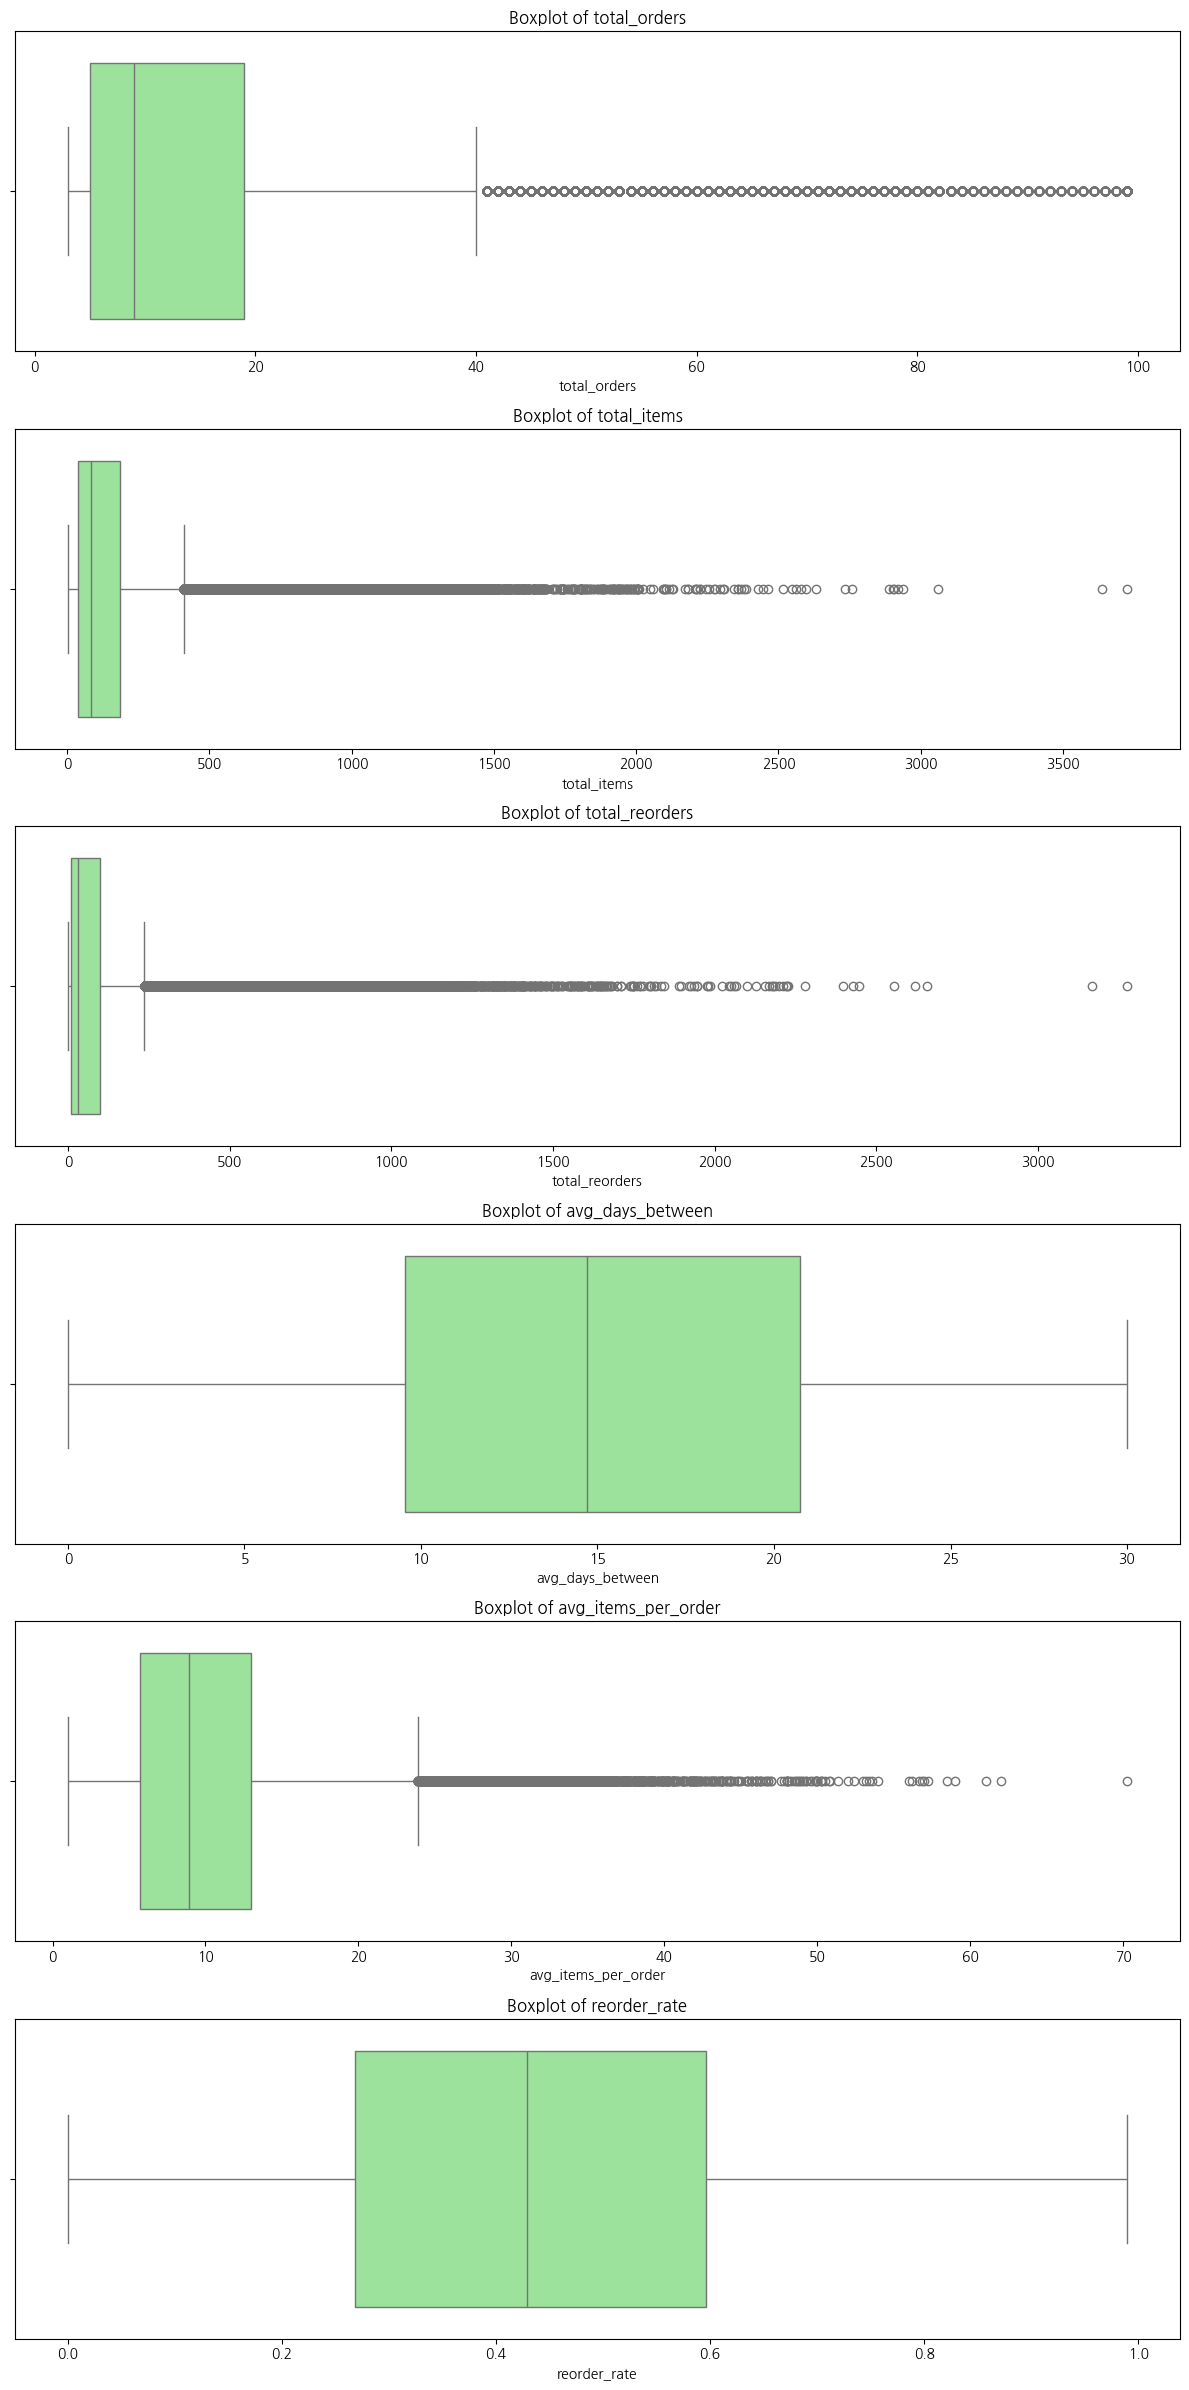

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Summary Statistics: 최대값, 평균, 표준편차 계산 및 출력
summary_stats = customer_segmentation.describe().T[['max', 'mean', 'std']]
print("Summary Statistics (Max, Mean, Std):")
display(summary_stats)

# 2. 결측치(Missing Values) 시각화
# 각 컬럼별 결측치 개수 계산
missing_values = customer_segmentation.isnull().sum()
print("Missing Values per column:")
print(missing_values)

plt.figure(figsize=(8, 6))
missing_values.plot(kind='bar', color='skyblue')
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")
plt.title("Missing Values per Column in customer_segmentation")
plt.tight_layout()
plt.show()

# 3. 이상치(Outlier) 시각화: 각 숫자형 피처에 대해 Boxplot 생성
# 분석 시 user_id는 식별자이므로 제외하고, 나머지 숫자형 변수에 대해 박스플롯 작성
numeric_cols = customer_segmentation.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'user_id' in numeric_cols:
    numeric_cols.remove('user_id')

plt.figure(figsize=(12, len(numeric_cols) * 4))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, idx)
    sns.boxplot(x=customer_segmentation[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# 결측치 검토 결과
# Boxplot of total_orders : 주문횟수

대부분의 고객은 5~20회을 기록, 극소수의 고객이 매우 많은 주문 횟수(오른쪽 꼬리가 긴 형태(우측 편향)

박스 밖(상한선 위)에 위치한 점 '주문 횟수가 매우 많은’고객들(또는 이상치)이다.

# Boxplot of total_items : 구매한 전체 상품 수
대부분의 고객은 적은 수의 상품을 구매하지만, 극소수 고객은 수백~수천 개의 상품을 구매해 큰 편차가 발생

우측으로 긴 꼬리를 가지며, 박스 바깥 점들이 구매량이 매우 높은 고객(이상치)

# Boxplot of total_reorders : 재구매한 총횟수

일부 고객은 재구매 횟수가 매우 많아 우측 꼬리가 길게 형성

재구매 횟수가 0에 가까운 고객(거의 재구매를 안 하는 고객)도 있을 수 있으며, 재구매를 많이 하는 고객은 박스 상단을 훌쩍 넘는 점(이상치)

# Boxplot of avg_days_between : 첫구매후 주문간 평균일수
대체로 2주정도가 가장 많다(1~2회/주)

최대 30일 이상 주문고객 존재
# Boxplot of avg_items_per_order

한 번 주문당 평균적으로 구매하는 상품 개수

보통 5~10개 정도이며 한번에 많은상품 25 ~70까지 존재

# Boxplot of reorder_rate

전체 상품중 재구매가 차지하는 비율

보통 0.3~0.6이며 1근처까지 올라가는 극단적인 재구매 비율 고객 소수 존재(이상치)

1. 이상치 그대로 분석

2. 이상치 처리후 분석

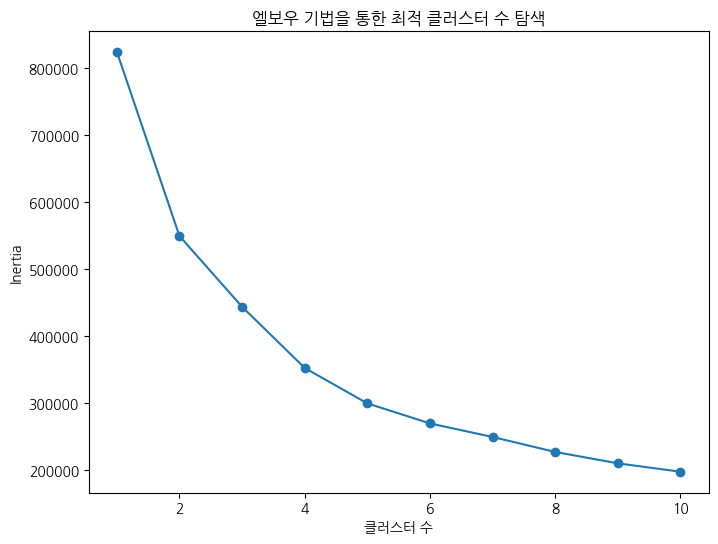

각 클러스터별 고객 수:
cluster
0    97901
1    78992
2    29316
Name: count, dtype: int64


,user_id,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate,cluster
0,1,10,59,41,20.259259,5.900000,0.694915,0
1,2,14,195,93,15.967033,13.928571,0.476923,0
2,3,12,88,55,11.487179,7.333333,0.625000,0
3,4,5,18,1,15.357143,3.600000,0.055556,1
4,5,4,37,14,14.500000,9.250000,0.378378,0


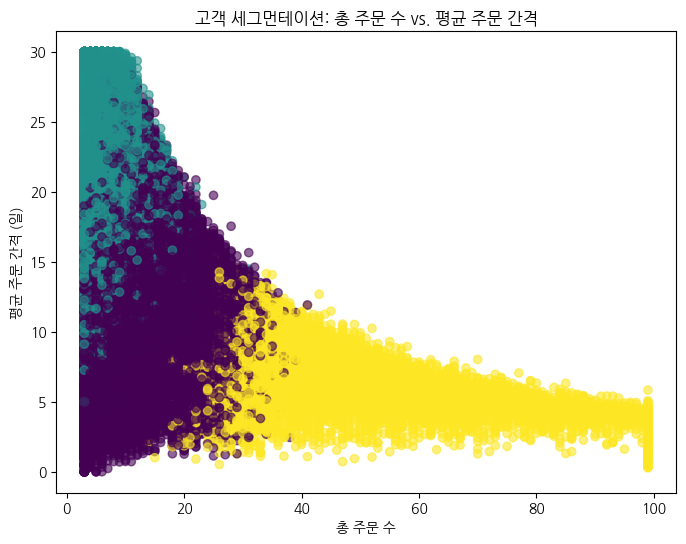

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 클러스터링에 사용할 주요 피처 선정
features = ['total_orders', 'avg_days_between', 'avg_items_per_order', 'reorder_rate']
X = customer_segmentation[features]

# 1. 피처 스케일링: 스케일 차이를 줄이기 위해 StandardScaler 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 엘보우(Elbow) 기법을 사용하여 최적의 클러스터 수 탐색
inertia = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('클러스터 수')
plt.ylabel('Inertia')
plt.title('엘보우 기법을 통한 최적 클러스터 수 탐색')
plt.show()

# 3. 최적 클러스터 수로 KMeans 적용 (클러스터 수 3로 결정)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_segmentation['cluster'] = kmeans.fit_predict(X_scaled)

# 4. 클러스터링 결과 확인
print("각 클러스터별 고객 수:")
print(customer_segmentation['cluster'].value_counts())
display(customer_segmentation.head())

# 5. 클러스터링 결과 시각화 (예: 총 주문 수 vs. 평균 주문 간격)
plt.figure(figsize=(8, 6))
plt.scatter(customer_segmentation['total_orders'], customer_segmentation['avg_days_between'],
            c=customer_segmentation['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('총 주문 수')
plt.ylabel('평균 주문 간격 (일)')
plt.title('고객 세그먼테이션: 총 주문 수 vs. 평균 주문 간격')
plt.show()

엘보우기법 :  k=3 또는 k=4가 비교적 적절한 클러스터 수로 판단

KMeans 결과 산점도 (총 주문 수 vs. 평균 주문 간격)

(보라) 총주문수 30회 이하가 많고, 평균주문일 10일이상이 많다. ▶신규고객, 이탈위험고객 가능

(청녹색) 총주문수 15일 이하가 많고, 평균주문일 15~30 분포 : ▶중간 충성도 고객

(노란색) 총주문수 40~100까지 많고, 평균주문일 10일 이하로 짧다: ▶핵심 충성도 고객

## 마케팅 전략
**‘충성 고객**’

추가 혜택(할인, 쿠폰)으로 재구매를 유도하거나 VIP 프로그램을 운영.

‘**저빈도 고객**’이나 **‘이탈 위험 고객’**

리마인드 알림이나 신규 추천 상품을 제공하여 주문 빈도를 늘리는 방안을 고려.

**상품 추천:**

각 군집별로 자주 구매하는 상품 카테고리를 분석해, 맞춤형 상품 추천을 진행.

**재고/물류 관리:**

주문 간격이 짧은 군집은 특정 시점에 수요가 집중될 가능성이 있으므로, 그에 맞춰 재고 관리나 물류 배치를 최적화할 수 있습니다.

각 클러스터별 고객 수:
cluster
3    78150
1    65457
0    35172
2    27430
Name: count, dtype: int64


,user_id,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate,cluster
0,1,10,59,41,20.259259,5.900000,0.694915,3
1,2,14,195,93,15.967033,13.928571,0.476923,0
2,3,12,88,55,11.487179,7.333333,0.625000,3
3,4,5,18,1,15.357143,3.600000,0.055556,1
4,5,4,37,14,14.500000,9.250000,0.378378,3


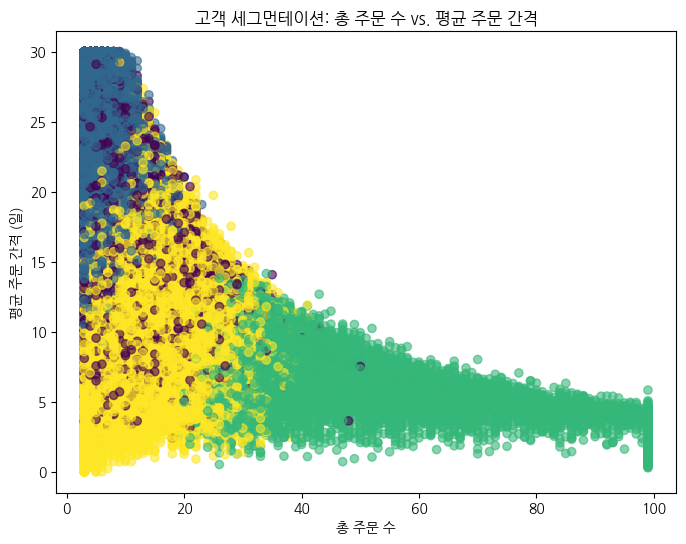

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 클러스터링에 사용할 주요 피처 선정
features = ['total_orders', 'avg_days_between', 'avg_items_per_order', 'reorder_rate']
X = customer_segmentation[features]

# 1. 피처 스케일링: 스케일 차이를 줄이기 위해 StandardScaler 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 최적 클러스터 수로 KMeans 적용 (클러스터 수 4로 결정)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_segmentation['cluster'] = kmeans.fit_predict(X_scaled)

# 3. 클러스터링 결과 확인
print("각 클러스터별 고객 수:")
print(customer_segmentation['cluster'].value_counts())
display(customer_segmentation.head())

# 4. 클러스터링 결과 시각화 (예: 총 주문 수 vs. 평균 주문 간격)
plt.figure(figsize=(8, 6))
plt.scatter(customer_segmentation['total_orders'], customer_segmentation['avg_days_between'],
            c=customer_segmentation['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('총 주문 수')
plt.ylabel('평균 주문 간격 (일)')
plt.title('고객 세그먼테이션: 총 주문 수 vs. 평균 주문 간격')
plt.show()

# 클러스터 특징
왼쪽 상단(주문 수 적고, 주문 간격이 길거나 중간 수준)

왼쪽 하단(주문 수 적고, 주문 간격이 짧은 편)

중간 영역(주문 수와 주문 간격이 모두 중간 정도)

오른쪽 하단(주문 수 많고, 주문 간격이 짧음)

**마케팅 전략**

* (오른쪽 하단) 충성 고객:

  VIP 프로그램, 추가 적립, 개인화 추천 등을 통해 유지 및 매출 극대화.

* (왼쪽 상단/하단) 저빈도·신규 고객:

  할인 쿠폰, 알림(푸시) 메시지, 개인화 추천으로 주문 빈도 상승 유도.

**상품 추천/프로모션**
* 각 클러스터별로 자주 구매하는 상품 카테고리를 분석하면, 클러스터 맞춤형 상품 추천이나 프로모션을 기획

**운영/재고 관리**
* **주문 간격이 짧고 주문 횟수가 많은 고객 클러스터**에서 특정 시기에 수요가 집중될 수 있으므로, 재고·물류를 효율적으로 운영해야됨.

##avg_items_per_order와 reorder_rate
사용 클러스터 검토


각 클러스터별 고객 수:
cluster
1    61590
2    56810
3    49027
0    38782
Name: count, dtype: int64


,user_id,total_orders,total_items,total_reorders,avg_days_between,avg_items_per_order,reorder_rate,cluster
0,1,10,59,41,18.457627,5.900000,0.694915,3
1,2,14,195,93,14.835897,13.928571,0.476923,0
2,3,12,88,55,10.068182,7.333333,0.625000,3
3,4,5,18,1,11.722222,3.600000,0.055556,2
4,5,4,37,14,9.891892,9.250000,0.378378,1


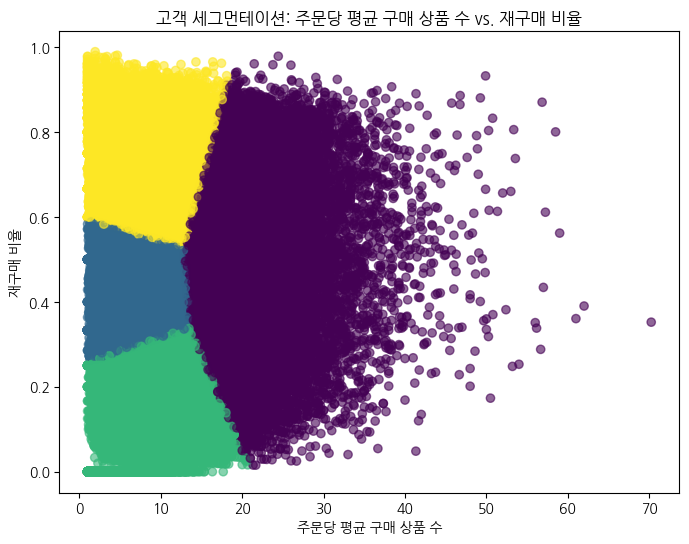

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 클러스터링에 사용할 피처 선정 (avg_items_per_order, reorder_rate)
features = ['avg_items_per_order', 'reorder_rate']
X = customer_segmentation[features]

# 2. 피처 스케일링 (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. KMeans 적용 (클러스터 수 = 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_segmentation['cluster'] = kmeans.fit_predict(X_scaled)

# 4. 클러스터링 결과 확인
print("각 클러스터별 고객 수:")
print(customer_segmentation['cluster'].value_counts())
display(customer_segmentation.head())

# 5. 클러스터링 결과 시각화 (avg_items_per_order vs. reorder_rate)
plt.figure(figsize=(8, 6))
plt.scatter(
    customer_segmentation['avg_items_per_order'],
    customer_segmentation['reorder_rate'],
    c=customer_segmentation['cluster'],
    cmap='viridis',
    alpha=0.6
)
plt.xlabel('주문당 평균 구매 상품 수')
plt.ylabel('재구매 비율')
plt.title('고객 세그먼테이션: 주문당 평균 구매 상품 수 vs. 재구매 비율')
plt.show()

x축: avg_items_per_order : 한 번의 주문에 평균적으로 구매하는 상품 수.

y축: reorder_rate : 전체 구매 상품 중 재구매(이미 샀던 상품을 다시 구매) 비율. 0에 가까울수록 ‘새로운 상품’

저(低) 아이템 수, 저(低) 재구매 비율


##베이지안 최적화 결과 최적 클러스터 수

In [15]:
pip install scikit-optimize #설치  scikit-optimize (skopt) 라이브러리

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.2 MB/s eta 0:00:00


베이지안 최적화 결과 최적 클러스터 수: 3
해당 k에서의 silhouette_score: 0.5503


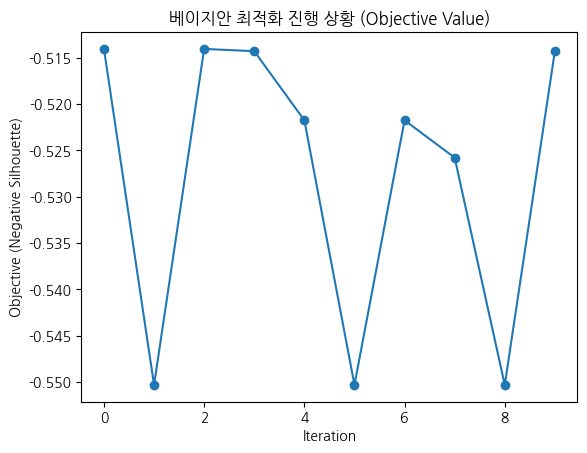


[전체 데이터에 대해 best_k 적용한 결과 예시]
cluster_opt
2    97810
1    82977
0    25422
Name: count, dtype: int64


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# KMeans, 평가 지표(silhouette_score) import
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# scikit-optimize 라이브러리
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

# --------------------------------------------------
# 0. (예시) 고객 세그먼트용 피처 선택
# --------------------------------------------------
# 예: avg_items_per_order, reorder_rate 만 사용
features = ['avg_items_per_order', 'reorder_rate']
X = customer_segmentation[features]

# --------------------------------------------------
# 1. 20% 데이터 무작위 추출 (초기 실험용)
# --------------------------------------------------
# random_state를 고정하면 재현 가능
X_sample = X.sample(frac=0.2, random_state=42)

# --------------------------------------------------
# 2. 베이지안 최적화(Bayesian Optimization)로
#    최적의 클러스터 수(k) 탐색
# --------------------------------------------------
# 탐색 범위: k=2 ~ k=10
search_space = [
    Integer(low=2, high=10, name='n_clusters')
]

@use_named_args(search_space)
def objective(n_clusters):
    """
    베이지안 최적화에서 평가할 목적함수.
    silhouette_score를 최대화하고자 하므로,
    gp_minimize에서는 '값이 낮을수록 좋다'고 판단하므로
    -1 * score(negative) 형태로 반환.
    """
    # KMeans 모델 생성 및 학습
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(X_sample)

    # 실루엣 점수 계산
    score = silhouette_score(X_sample, labels)

    # gp_minimize는 '값이 낮을수록 좋은' 함수를 최소화
    # 실루엣 점수는 높을수록 좋으므로 부호를 바꿔서 반환
    return -score

# --------------------------------------------------
# 3. gp_minimize로 베이지안 최적화 실행
#    (n_calls=10: 최대 10회 반복)
# --------------------------------------------------
res = gp_minimize(
    func=objective,          # 목적함수
    dimensions=search_space, # 탐색 범위
    n_calls=10,              # 반복 횟수
    random_state=42
)

# --------------------------------------------------
# 4. 결과 확인
# --------------------------------------------------
best_k = res.x[0]
best_score = -res.fun  # 부호를 바꿔서 계산
print(f"베이지안 최적화 결과 최적 클러스터 수: {best_k}")
print(f"해당 k에서의 silhouette_score: {best_score:.4f}")

# 추가: 최적화 과정 시각화 (선택 사항)
# res.func_vals에는 각 반복에서의 objective 함수 값(음수화된 silhouette)이 저장됨
plt.plot(res.func_vals, marker='o')
plt.title("베이지안 최적화 진행 상황 (Objective Value)")
plt.xlabel("Iteration")
plt.ylabel("Objective (Negative Silhouette)")
plt.show()

# --------------------------------------------------
# 5. 최적 k로 전체 데이터에 KMeans 적용 (선택 사항)
# --------------------------------------------------
kmeans_optimal = KMeans(n_clusters=best_k, random_state=42)
customer_segmentation['cluster_opt'] = kmeans_optimal.fit_predict(X)

print("\n[전체 데이터에 대해 best_k 적용한 결과 예시]")
print(customer_segmentation['cluster_opt'].value_counts())

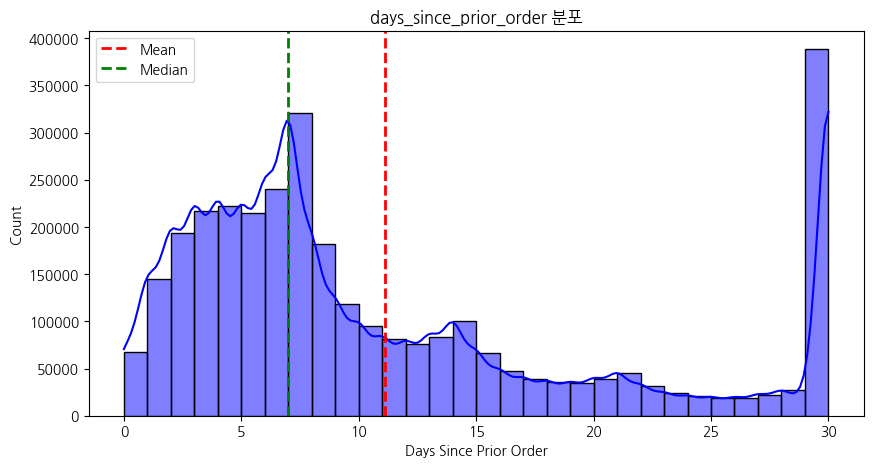

In [ ]:
# 데이터 분포 분석

plt.figure(figsize=(10, 5))
sns.histplot(orders_df["days_since_prior_order"].dropna(), bins=30, kde=True, color='blue')
plt.axvline(orders_df["days_since_prior_order"].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.axvline(orders_df["days_since_prior_order"].median(), color='green', linestyle='dashed', linewidth=2, label="Median")
plt.title("days_since_prior_order 분포")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Count")
plt.legend()
plt.show()

대부분이 7일 이내에 집중된 많은사용자가 매주 반복주문 경향

평균선이 중앙값보다 오른쪽에 위치 오른쪽 꼬리가 긴분포(대부분 7일이내 주문)

30일지점에서 주문량급증(특정 월간 구매 패턴 사용자 존재)

# 결측치 처리 방법
결측치 제거 : 첫 주문 일부 사용자의 정보 손실가능

평균값으로 대체 : 평균이 오른쪽으로 꼬리가 길어 평균이 비정상 확률높다

중앙값으로 대체 : 중앙값이 7일이라 대체값으로 가능성 있다.

**첫주문인 경우는 -1로 이전에 주문이 없다는 뜻으로 -1로 대체**

In [ ]:
# 결측치를 -1로 대체 하여 (이전 주문이 없다 = 첫 주문이라는 뜻)
orders_df["days_since_prior_order"] = orders_df["days_since_prior_order"].fillna(-1)

# 첫 주문 여부를 나타내는 새로운 컬럼 추가
orders_df["first_order"] = (orders_df["days_since_prior_order"] == -1).astype(int)
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,first_order
0,2539329,1,prior,1,2,8,-1.0,1
1,2398795,1,prior,2,3,7,15.0,0
2,473747,1,prior,3,3,12,21.0,0
3,2254736,1,prior,4,4,7,29.0,0
4,431534,1,prior,5,4,15,28.0,0
...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,0
3421079,1854736,206209,prior,11,4,10,30.0,0
3421080,626363,206209,prior,12,1,12,18.0,0
3421081,2977660,206209,prior,13,1,12,7.0,0


In [ ]:
# 결측치 확인
for name, df in dataframes.items():
    print(f"{name.upper()} 데이터셋 결측치 확인")
    print(df.isnull().sum(), "\n")

AISLES_DF 데이터셋 결측치 확인
aisle_id    0
aisle       0
dtype: int64 

DEPARTMENTS_DF 데이터셋 결측치 확인
department_id    0
department       0
dtype: int64 

ORDERS_DF 데이터셋 결측치 확인
order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
first_order               0
dtype: int64 

ORDER_PRODUCTS_PRIOR_DF 데이터셋 결측치 확인
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64 

ORDER_PRODUCTS_TRAIN_DF 데이터셋 결측치 확인
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64 

PRODUCTS_DF 데이터셋 결측치 확인
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64 



In [ ]:
# days_since_prior_order가 -1인 행 필터링
first_order_rows = orders_df.loc[orders_df["days_since_prior_order"] == -1]

# 필터링된 데이터 확인
print(first_order_rows)  # 전체 출력

# 만약 데이터 상위 10개만 출력
print(first_order_rows.head(10))

display(first_order_rows)

         order_id  user_id eval_set  order_number  order_dow  \
0         2539329        1    prior             1          2   
11        2168274        2    prior             1          2   
26        1374495        3    prior             1          1   
39        3343014        4    prior             1          6   
45        2717275        5    prior             1          3   
...           ...      ...      ...           ...        ...   
3420930    969311   206205    prior             1          4   
3420934   3189322   206206    prior             1          3   
3421002   2166133   206207    prior             1          6   
3421019   2227043   206208    prior             1          1   
3421069   3154581   206209    prior             1          3   

         order_hour_of_day  days_since_prior_order  first_order  
0                        8                    -1.0            1  
11                      11                    -1.0            1  
26                      14       

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,first_order
0,2539329,1,prior,1,2,8,-1.0,1
11,2168274,2,prior,1,2,11,-1.0,1
26,1374495,3,prior,1,1,14,-1.0,1
39,3343014,4,prior,1,6,11,-1.0,1
45,2717275,5,prior,1,3,12,-1.0,1
...,...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,-1.0,1
3420934,3189322,206206,prior,1,3,18,-1.0,1
3421002,2166133,206207,prior,1,6,19,-1.0,1
3421019,2227043,206208,prior,1,1,15,-1.0,1


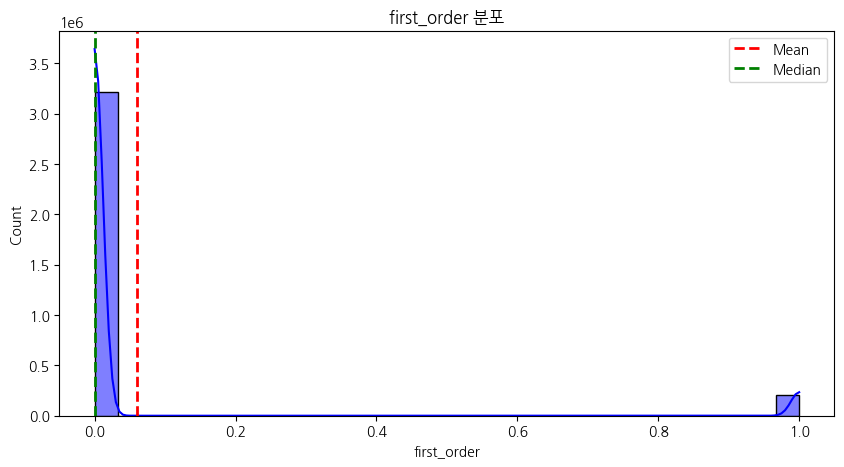

In [ ]:
# first_order 데이터 분포 분석

plt.figure(figsize=(10, 5))
sns.histplot(orders_df["first_order"].dropna(), bins=30, kde=True, color='blue')
plt.axvline(orders_df["first_order"].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.axvline(orders_df["first_order"].median(), color='green', linestyle='dashed', linewidth=2, label="Median")
plt.title("first_order 분포")
plt.xlabel("first_order")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
orders_df["first_order"].unique()

array([1, 0])

In [ ]:
# first_order 값 비율 계산 (퍼센트 단위)
first_order_ratio = orders_df["first_order"].value_counts(normalize=True) * 100

# 비율 출력
print("first_order 값 비율:")
print(first_order_ratio)

first_order 값 비율:
first_order
0    93.972406
1     6.027594
Name: proportion, dtype: float64


In [ ]:
# A와 B의 'C' 컬럼이 인덱스와 순서까지 완전히 동일하면 True를 반환합니다.
if orders_df["order_id"].equals(order_products_prior_df["order_id"]):
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일합니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.")


두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.


In [ ]:
# A와 B의 'C' 컬럼이 인덱스와 순서까지 완전히 동일하면 True를 반환합니다.
if order_products_train_df["order_id"].equals(order_products_prior_df["order_id"]):
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일합니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.")

두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.


In [ ]:
# A와 B의 'C' 컬럼이 인덱스와 순서까지 완전히 동일하면 True를 반환합니다.
if order_products_train_df["order_id"].equals(orders_df["order_id"]):
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일합니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.")

두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_train_df["order_id"].dropna()) == set(orders_df["order_id"].dropna()):
    print("두 테이블의 'order_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_prior_df["order_id"].dropna()) == set(orders_df["order_id"].dropna()):
    print("두 테이블의 'order_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_prior_df["order_id"].dropna()) == set(order_products_train_df["order_id"].dropna()):
    print("두 테이블의 'order_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_prior_df["product_id"].dropna()) == set(order_products_train_df["product_id"].dropna()):
    print("두 테이블의 'product_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(products_df["product_id"].dropna()) == set(order_products_train_df["product_id"].dropna()):
    print("두 테이블의 'product_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(products_df["product_id"].dropna()) == set(order_products_prior_df["product_id"].dropna()):
    print("두 테이블의 'product_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# 1. 데이터프레임 크기(shape) 비교
print("\n[데이터프레임 크기 비교]")
print("order_products_prior_df shape:", order_products_prior_df.shape)
print("order_products_train_df shape:", order_products_train_df.shape)

# 2. 기본 통계량 비교
print("\n[기본 통계량 비교]")
print("\norder_products_prior_df 통계량:")
print(order_products_prior_df.describe())
print("\norder_products_train_df 통계량:")
print(order_products_train_df.describe())

# 3. 결측치 개수 비교
print("\n[결측치 개수 비교]")
print("\norder_products_prior_df 결측치:")
print(order_products_prior_df.isnull().sum())
print("\norder_products_train_df 결측치:")
print(order_products_train_df.isnull().sum())

# 4. 두 데이터프레임의 차이 확인 (shape이 동일할 때만 비교)
if order_products_prior_df.shape == order_products_train_df.shape:
    print("\n[값이 다른 부분 확인]")
    diff_df = order_products_prior_df.compare(order_products_train_df)
    print(diff_df)
else:
    print("\n데이터프레임의 shape이 다르므로 값을 직접 비교할 수 없습니다.")

# 5. 각 컬럼의 고유값 개수 비교
print("\n[고유값 개수 비교]")
print("\norder_products_prior_df 고유값 개수:")
print(order_products_prior_df.nunique())
print("\norder_products_train_df 고유값 개수:")
print(order_products_train_df.nunique())


[데이터프레임 크기 비교]
order_products_prior_df shape: (32434489, 4)
order_products_train_df shape: (1384617, 4)

[기본 통계량 비교]

order_products_prior_df 통계량:
           order_id    product_id  add_to_cart_order     reordered
count  3.243449e+07  3.243449e+07       3.243449e+07  3.243449e+07
mean   1.710749e+06  2.557634e+04       8.351076e+00  5.896975e-01
std    9.873007e+05  1.409669e+04       7.126671e+00  4.918886e-01
min    2.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.559430e+05  1.353000e+04       3.000000e+00  0.000000e+00
50%    1.711048e+06  2.525600e+04       6.000000e+00  1.000000e+00
75%    2.565514e+06  3.793500e+04       1.100000e+01  1.000000e+00
max    3.421083e+06  4.968800e+04       1.450000e+02  1.000000e+00

order_products_train_df 통계량:
           order_id    product_id  add_to_cart_order     reordered
count  1.384617e+06  1.384617e+06       1.384617e+06  1.384617e+06
mean   1.706298e+06  2.555624e+04       8.758044e+00  5.985944e-01
std    9.897326e+0

결론:

"Train 데이터셋은 전체 주문 내역(prior 데이터셋)의 대표성을 어느 정도 보유

재주문(reordered) 예측과 같은 모델링 작업에 활용하기에 적합하나,

주문 시 아이템 담기 순서(add_to_cart_order)의 범위 차이와 같이 두 데이터셋 간 일부 변수에서 차이가 있어,

해당 변수의 특성을 면밀히 분석하고 추가적인 전처리 또는 feature engineering을 고려해야 함.

**주문 데이터 (orders.csv) 분석**

<ipython-input-26-d8e55188e112>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders_df, x='order_dow', palette="viridis")


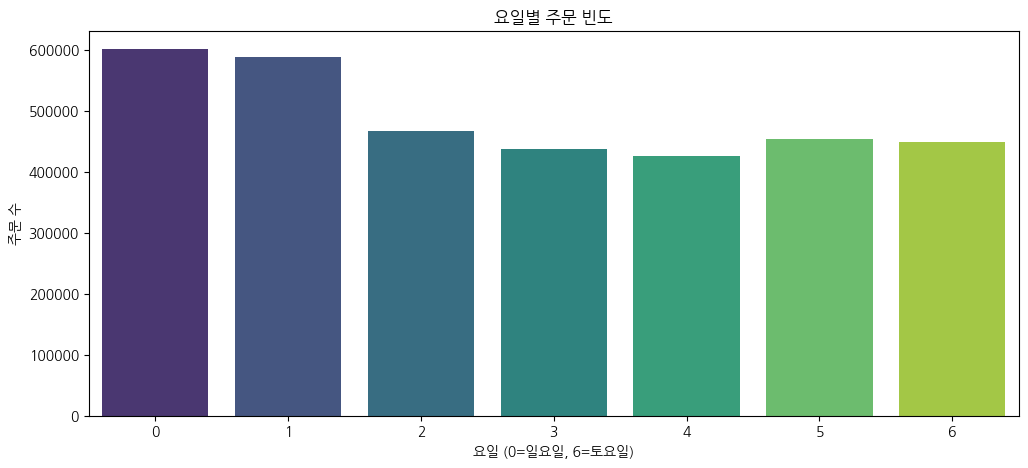

<ipython-input-26-d8e55188e112>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders_df, x='order_hour_of_day', palette="viridis")


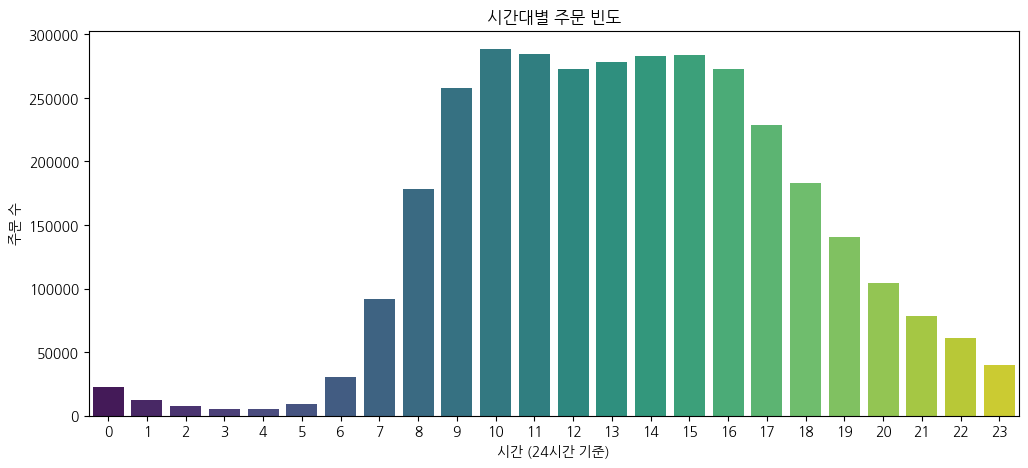

In [ ]:
# 주문 요일 및 시간 분포
plt.figure(figsize=(12,5))
sns.countplot(data=orders_df, x='order_dow', palette="viridis")
plt.title("요일별 주문 빈도")
plt.xlabel("요일 (0=일요일, 6=토요일)")
plt.ylabel("주문 수")
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(data=orders_df, x='order_hour_of_day', palette="viridis")
plt.title("시간대별 주문 빈도")
plt.xlabel("시간 (24시간 기준)")
plt.ylabel("주문 수")
plt.show()



**제품 데이터 분석 (products.csv, aisles.csv, departments.csv)**

<ipython-input-27-83f31e650dbd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, y='product_name', x='count', palette="mako")


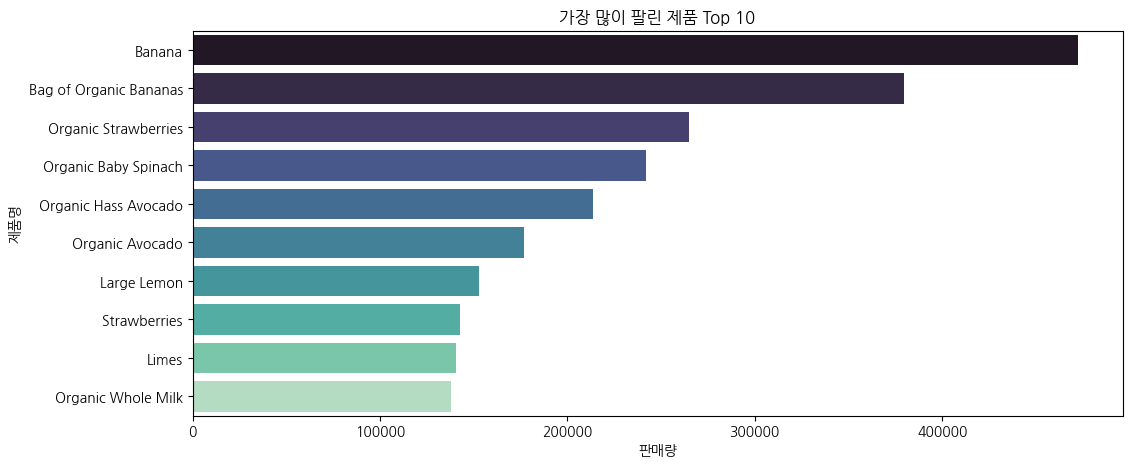

In [ ]:
# 제품 정보 병합
products_df = products_df.merge(aisles_df, on="aisle_id", how="left")
products_df = products_df.merge(departments_df, on="department_id", how="left")

# 가장 많이 팔린 제품 확인
top_products = order_products_prior_df['product_id'].value_counts().head(10)
top_products = top_products.reset_index()
top_products.columns = ['product_id', 'count']
top_products = top_products.merge(products_df, on="product_id", how="left")

plt.figure(figsize=(12,5))
sns.barplot(data=top_products, y='product_name', x='count', palette="mako")
plt.title("가장 많이 팔린 제품 Top 10")
plt.xlabel("판매량")
plt.ylabel("제품명")
plt.show()

**PCA(주성분 분석) 및 t-SNE 적용**

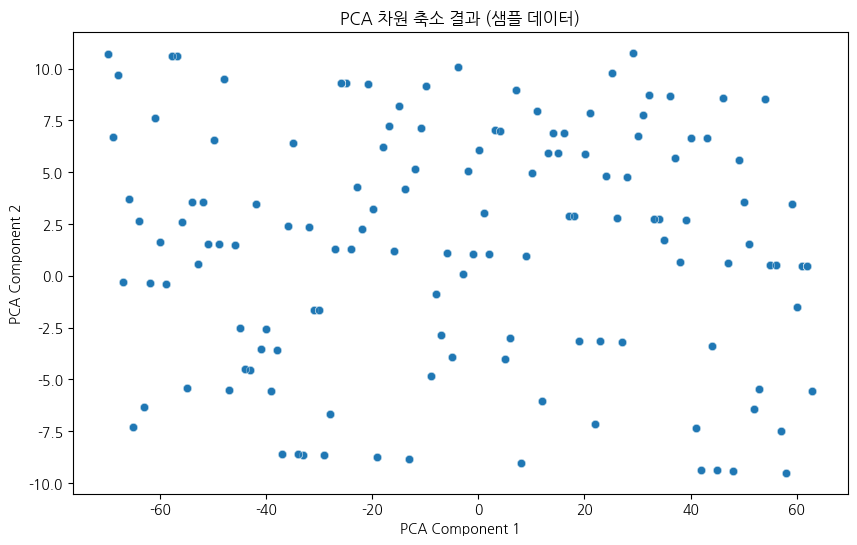

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. 데이터 로드 (파일 경로 수정)
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__prior.csv')
products_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/products.csv')

# 2. 주문별 데이터 병합
merged_df = order_products_prior_df.merge(
    products_df[['product_id', 'department_id', 'aisle_id']],
    on="product_id",
    how="left"
)

# 3. 메모리 사용량 감소를 위해 일부 샘플 데이터 선택 (50,000행)
sample_df = merged_df.sample(n=50000, random_state=42)

# 4. PCA 적용 (department_id, aisle_id 컬럼에 대해)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_df[['department_id', 'aisle_id']])
sample_df['pca_1'] = pca_result[:, 0]
sample_df['pca_2'] = pca_result[:, 1]

# 5. 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca_1', y='pca_2', data=sample_df, alpha=0.5)
plt.title("PCA 차원 축소 결과 (샘플 데이터)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

x축 방향 분산이 y축보다 큰 경우, department_id와 aisle_id 간 차이가 주로 첫 번째 주성분에 반영되었다고 해석할 수 있음

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

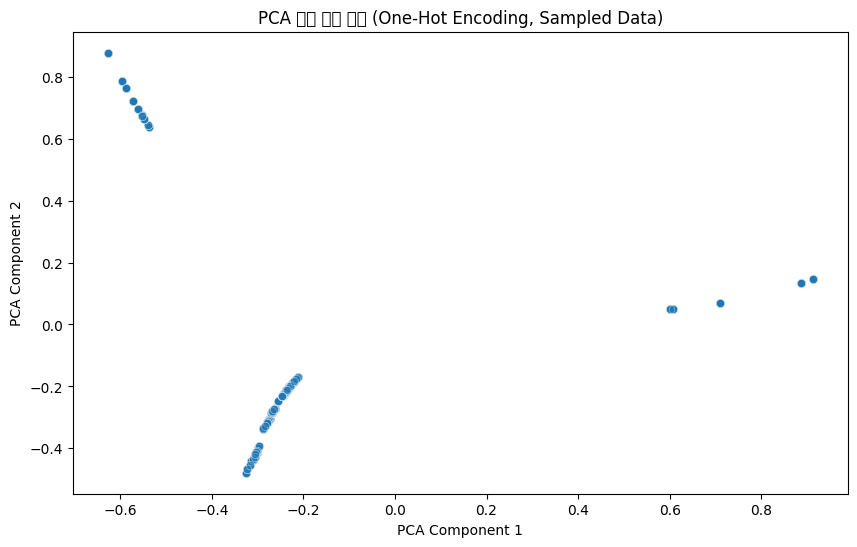

In [ ]:
# One-Hot Encoding 시도후 PCA적용
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. order_products_prior_df와 products_df 병합
merged_df = order_products_prior_df.merge(
    products_df[['product_id', 'department_id', 'aisle_id']],
    on='product_id',
    how='left'
)

# 2. 메모리 사용량 줄이기 위해 샘플 데이터 선택 (예: 100,000행)
sample_df = merged_df.sample(n=100000, random_state=42)

# 3. One-Hot Encoding (sparse_output=False를 사용하여 밀집 배열 반환)
ohe = OneHotEncoder(sparse_output=False)
encoded_features = ohe.fit_transform(sample_df[['department_id', 'aisle_id']])

# 4. PCA 적용 (2차원)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_features)

# 5. 결과를 sample_df에 저장
sample_df['pca_1'] = pca_result[:, 0]
sample_df['pca_2'] = pca_result[:, 1]

# 6. 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca_1', y='pca_2', data=sample_df, alpha=0.5)
plt.title("PCA 차원 축소 결과 (One-Hot Encoding, Sampled Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

산점도가 서로 떨어진 몇 개의 구역으로 나뉜다.

**department_id와 aisle_id의 특정 조합이 데이터의 분산을 크게 지배하고 있음**

극단적으로 분리된 형태로 나타나는 경우:

군집화(예: K-means, DBSCAN)나 t-SNE, UMAP 등의 다른 차원 축소 기법을 시도해보거나, 범주를 합치는 전처리필요.

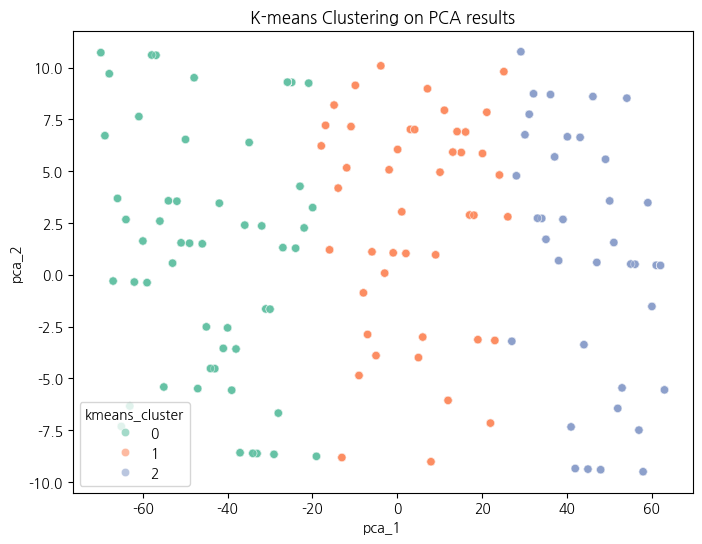

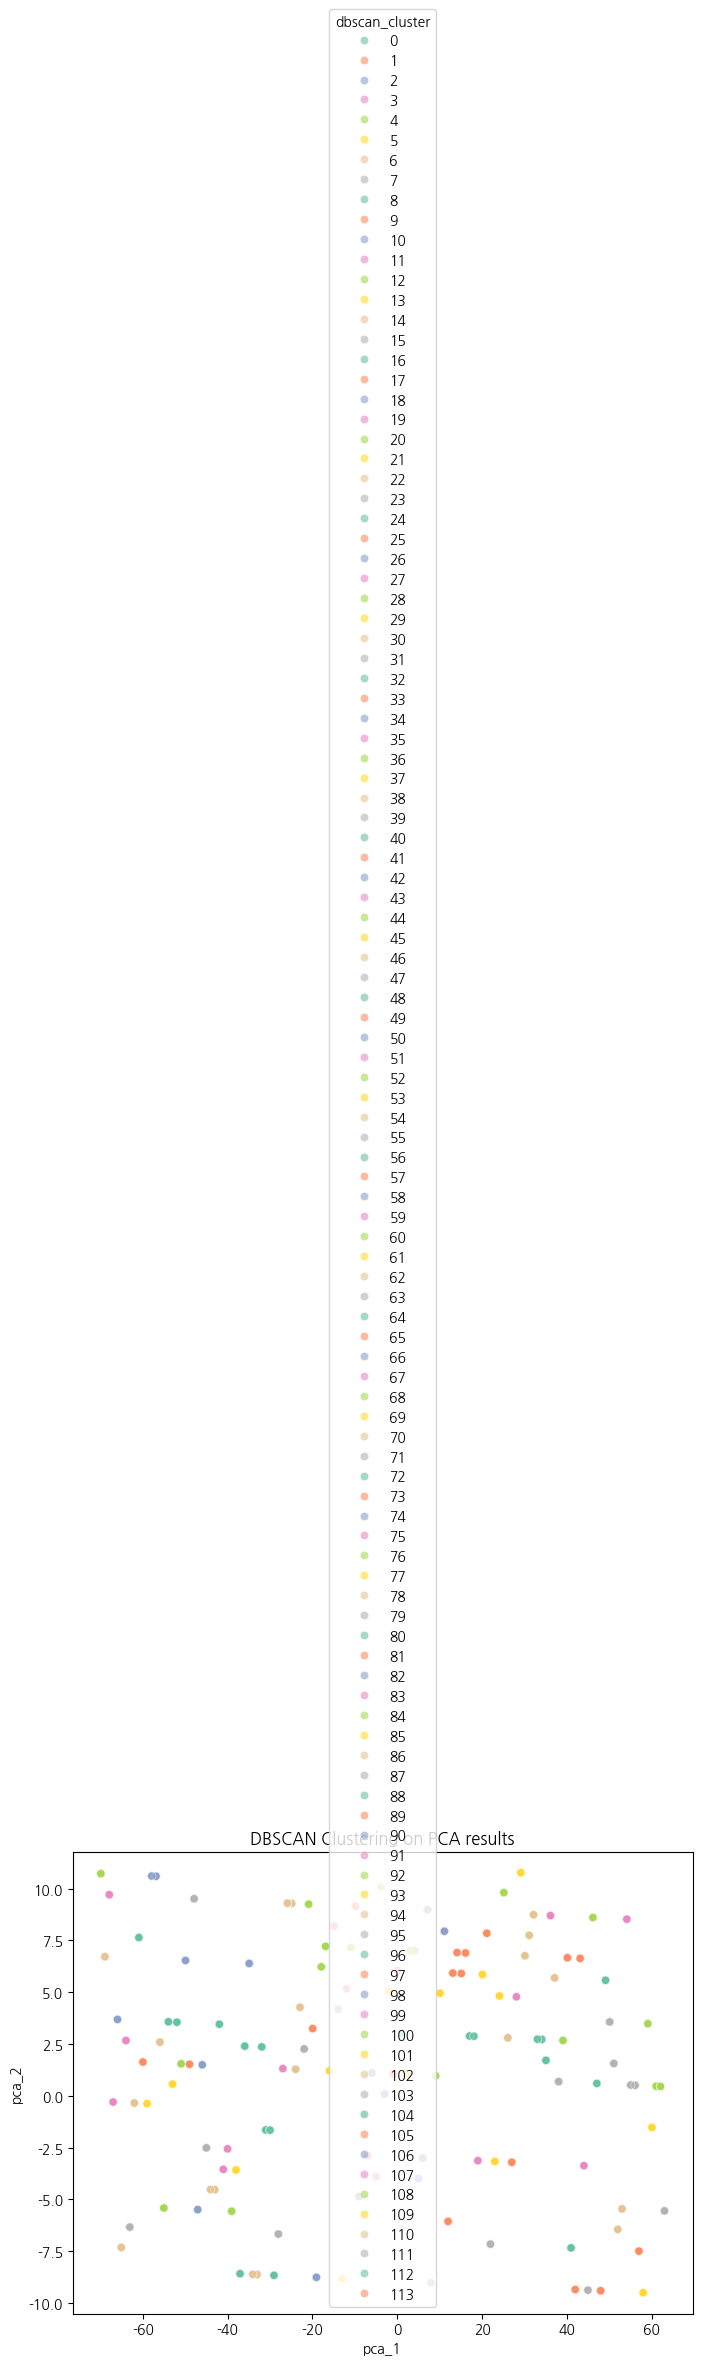

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# 1. 데이터 로드 (파일 경로 수정)
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__prior.csv')
products_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/products.csv')

# 2. 주문별 데이터 병합
merged_df = order_products_prior_df.merge(
    products_df[['product_id', 'department_id', 'aisle_id']],
    on="product_id",
    how="left"
)

# 3. 메모리 사용량 감소를 위해 일부 샘플 데이터 선택 (50,000행)
sample_df = merged_df.sample(n=50000, random_state=42)

# 4. PCA 적용 (department_id, aisle_id 컬럼에 대해)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_df[['department_id', 'aisle_id']])
sample_df['pca_1'] = pca_result[:, 0]
sample_df['pca_2'] = pca_result[:, 1]

# === K-means 클러스터링 ===
# 1) K-means 모델 정의 (클러스터 개수 n_clusters=3은 예시)
kmeans = KMeans(n_clusters=3, random_state=42)

# 2) 클러스터 예측 (pca_1, pca_2를 사용)
sample_df['kmeans_cluster'] = kmeans.fit_predict(sample_df[['pca_1', 'pca_2']])

# 3) K-means 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    data=sample_df,
    hue='kmeans_cluster',
    palette='Set2',
    alpha=0.6
)
plt.title("K-means Clustering on PCA results")
plt.show()

# === DBSCAN 클러스터링 ===
# 1) DBSCAN 모델 정의 (eps, min_samples는 데이터 특성에 맞춰 조정)
dbscan = DBSCAN(eps=1.5, min_samples=5)

# 2) 클러스터 예측
sample_df['dbscan_cluster'] = dbscan.fit_predict(sample_df[['pca_1', 'pca_2']])

# 3) DBSCAN 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    data=sample_df,
    hue='dbscan_cluster',
    palette='Set2',
    alpha=0.6
)
plt.title("DBSCAN Clustering on PCA results")
plt.show()

**K-means 결과 (n_clusters=3)**

실제 데이터에 자연스러운 군집 구조가 없더라도 3개로 구분됨.

각 클러스터가 실제 어떤 특성을 갖는지는, 원래 변수(aisle_id, department_id)와의 연관성을 추가 분석필요.

**DBSCAN 결과 (eps=1.5, min_samples=5)**

점들이 얼마나 조밀하게 모여 있느냐를 기준으로 군집을 형성

밀도가 높아 연속적으로 모여 있는 구간을 찾아내고,
외곽의 희소한 점들은 노이즈(-1) 로 분류.
eps와 min_samples에 따라 클러스터 개수와 노이즈 비율이 크게 달라짐.

군집이 여러 개로 나뉠 수 있고, K-means처럼 "몇 개로 나누겠다"고 미리 정하지 않아도됨.

**범주형 변수에 대한 PCA & 군집화는 다소 인사이트가 제한될 수 있으며, 추가적인 변수(예: 구매 빈도, 사용자 특성 등)나 인코딩 방식을 바꿔 보면 더 유의미한 군집 구조가 나타날 수 있습니다.**

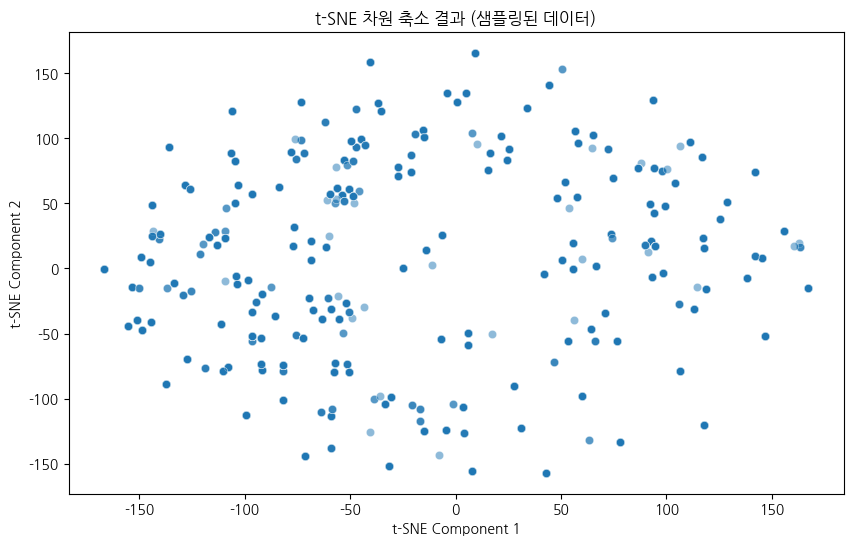

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# 전체 데이터 대신 일부 샘플을 선택 (예: 5,000행)
sample_df = merged_df.sample(n=5000, random_state=42)

# t-SNE 적용 (샘플 데이터에 대해)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(sample_df[['department_id', 'aisle_id']])

sample_df['tsne_1'] = tsne_result[:, 0]
sample_df['tsne_2'] = tsne_result[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='tsne_1', y='tsne_2', data=sample_df, alpha=0.5)
plt.title("t-SNE 차원 축소 결과 (샘플링된 데이터)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

t-SNE 비선형 차원 축소 기법

유사한 점들은 가까이, 유사하지 않은 점들은 멀리 배치하는 데 초점을 맞춤

원래 변수가 단 2개(department_id, aisle_id) 뿐이며, 게다가 정수 범주형 변수이므로 t-SNE로 얻을 수 있는 이점이 제한적일 수 있다.

넓게 퍼진 단일 구름 형태로 보이는 두 컬럼(department_id, aisle_id)만으로는 뚜렷한 군집 구조가 발견되지 않았음.

5,000개 샘플에 대해 정수 범주형 변수 2개로 t-SNE를 수행한 결과로, 뚜렷한 군집 구조 없이 점들이 전체적으로 퍼진 형태를 확인.

t-SNE가 고차원 데이터의 복잡한 구조를 시각화하는 데 강점이 있지만, 이 경우처럼 변수가 적고 범주형인 상황에서는 유의미한 군집을 발견하기 어려울 수 있다.
**추가 변수, 인코딩 기법, 하이퍼파라미터 조정 등을 통해 더 풍부한 인사이트를 얻을 수 있다.**


In [ ]:
# 예제 데이터
y_true = np.array([3, 5, 2, 8, 7])
y_pred = np.array([2.5, 5, 2, 7, 8])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



MAE: 0.50
RMSE: 0.67
R² Score: 0.91


## **결론**

1. 차원 축소(PCA, t-SNE)를 통해 제품 특징을 요약 가능
2. K-means 및 DBSCAN을 활용한 군집 분석 가능
3. 모델 성능 평가 시 MAE, RMSE, R² 활용
4. 구매 패턴 및 재구매율을 고려하여 모델링 가능

팀원들과 분석 결과를 공유